# Create climatology and persistence forecasts

In this note book we will create the most basic baselines: persistence and climatology forecasts. We will do this for 500hPa geopotential, 850hPa temperature, precipitation and 2 meter temperature.

In [2]:
%load_ext autoreload
%autoreload 2
import warnings
#warnings.filterwarnings('ignore')
import os
NOTEBOOK_DIR="/g/data/wb00/admin/testing/weatherbench/NCI_notebooks"
os.chdir(NOTEBOOK_DIR)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from src.score import *
import logging 
import xarray as xr
import dask
from dask.distributed import Client
import gc
from dask.diagnostics import ProgressBar
import IPython
from IPython.display import Javascript
from datetime import datetime
#from dask.distributed import progress
# initialize workers
client = Client(n_workers=12, threads_per_worker=1)  
client

/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.events-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.wa

<Client: 'tcp://127.0.0.1:35605' processes=12 threads=12, memory=376.56 GiB>

In [4]:
sns.set_style('darkgrid')
sns.set_context('notebook')

## Load data - '5.625'

First, we need to specify the directories and load the data.

In [5]:
res = '5.625'
DATADIR = f'/g/data/wb00/NCI-Weatherbench/{res}deg' # Location of WeatherBench dataset
print(DATADIR)
PREDDIR = f"/scratch/vp91/{os.environ['USER']}/NCI-Weatherbench/pred_dir" # Location to store baseline forecasts
print(PREDDIR)
! mkdir -p {PREDDIR} 

/g/data/wb00/NCI-Weatherbench/5.625deg
/scratch/vp91/mah900/NCI-Weatherbench/pred_dir


In [6]:
!ls $DATADIR

10m_u_component_of_wind  potential_vorticity	       total_cloud_cover
10m_v_component_of_wind  relative_humidity	       total_precipitation
2m_temperature		 specific_humidity	       u_component_of_wind
constants.nc		 temperature		       v_component_of_wind
geopotential		 toa_incident_solar_radiation  vorticity


In [7]:
xr.open_mfdataset(f'{DATADIR}/2m_temperature/*.nc', combine='by_coords', parallel=True)

<xarray.Dataset>
Dimensions:  (time: 561024, lat: 32, lon: 64)
Coordinates:
  * time     (time) datetime64[ns] 1959-01-01 ... 2022-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    t2m      (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [8]:
%%time
print( datetime.now().strftime("%H:%M:%S") )
# Load the entire dataset for the relevant variables
z500 = xr.open_mfdataset(get_files_list(f'{DATADIR}/geopotential/'), combine='by_coords', parallel=True, chunks={'time': 10}).z.sel(level=500).load()  
t850 = xr.open_mfdataset(get_files_list(f'{DATADIR}/temperature/'),  combine='by_coords', parallel=True, chunks={'time': 10}).t.sel(level=850).drop('level').load()  
# convert to 6 hourly accumulation
tp  = xr.open_mfdataset(get_files_list(f'{DATADIR}/total_precipitation/'), combine='by_coords', parallel=True, chunks={'time': 10}).tp.rolling(time=6).sum().load()  
t2m = xr.open_mfdataset(get_files_list(f'{DATADIR}/2m_temperature/'),     combine='by_coords', parallel=True, chunks={'time': 10}).t2m.load()  
tp.name = 'tp'
#with ProgressBar():
data = xr.merge([z500, t850, tp, t2m]).compute()

03:28:27


/opt/conda/envs/mlenv/lib/python3.9/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 63.36 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 20min 50s, sys: 1min 39s, total: 22min 29s
Wall time: 29min 20s


In [9]:
%%time
print( datetime.now().strftime("%H:%M:%S") )
# Load the validation subset of the data: 2017 and 2018
#z500_valid = load_test_data.drop('level')(f'{DATADIR}geopotential_500', 'z')
#t850_valid = load_test_data(f'{DATADIR}temperature_850', 't')
z500_valid = load_test_data(f'{DATADIR}/geopotential/', 'z', slice('2021', '2022')) #slice('2021', '2022'))
t850_valid = load_test_data(f'{DATADIR}/temperature/',  't', slice('2021', '2022')) #slice('2021', '2022'))

tp_valid = load_test_data(f'{DATADIR}/total_precipitation/', 'tp', slice('2021', '2022')).rolling(time=6).sum()
tp_valid.name = 'tp'
t2m_valid = load_test_data(f'{DATADIR}/2m_temperature/', 't2m', slice('2021', '2022')) #slice('2021', '2022'))
#with ProgressBar():
valid_data = xr.merge([z500_valid, t850_valid, tp_valid, t2m_valid]).compute()

03:57:47
var: z
var: t
var: tp
var: t2m
CPU times: user 28.6 s, sys: 1.75 s, total: 30.3 s
Wall time: 32.5 s


## Persistence

Persistence simply means: Tomorrow's weather is today's weather.

In [10]:
def create_persistence_forecast(ds, lead_time_h):
    assert lead_time_h > 0, 'Lead time must be greater than 0'
    ds_fc = ds.isel(time=slice(0, -lead_time_h))
    return ds_fc

In [11]:
lead_times = xr.DataArray(
    np.arange(6, 126, 6), dims=['lead_time'], coords={'lead_time': np.arange(6, 126, 6)}, name='lead_time')

In [12]:
persistence = []
for l in lead_times:
    persistence.append(create_persistence_forecast(valid_data, int(l)))
persistence = xr.concat(persistence, dim=lead_times)

In [13]:
persistence

<xarray.Dataset>
Dimensions:    (time: 17514, lat: 32, lon: 64, lead_time: 20)
Coordinates:
  * time       (time) datetime64[ns] 2021-01-01 ... 2022-12-31T17:00:00
  * lat        (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon        (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lead_time  (lead_time) int64 6 12 18 24 30 36 42 ... 90 96 102 108 114 120
Data variables:
    z          (lead_time, time, lat, lon) float32 4.864e+04 4.864e+04 ... nan
    t          (lead_time, time, lat, lon) float32 254.0 254.0 253.9 ... nan nan
    tp         (lead_time, time, lat, lon) float32 nan nan nan ... nan nan nan
    t2m        (lead_time, time, lat, lon) float32 242.9 242.4 241.9 ... nan nan

The forecast files have dimensions `[init_time, lead_time, lat, lon]`. Let's now save these files so we can evaluate them later.

In [14]:
# Save the predictions
print ('Saving results:', f'{PREDDIR}/persistence_{res}.nc')
persistence.to_netcdf(    f'{PREDDIR}/persistence_{res}.nc')
#!ls '{PREDDIR}/persistence_{res}.nc'

Saving results: /scratch/vp91/mah900/NCI-Weatherbench/pred_dir/persistence_5.625.nc


## Climatology

First let's create a single climatology from the entire training dataset (meaning everything before 2021) #2017).

In [15]:
def create_climatology_forecast(ds_train):
    return ds_train.mean('time')

In [16]:
#train_data = data.sel(time=slice(None, '2016'))
train_data = data.sel(time=slice('1959', '2020'))

In [17]:
climatology = create_climatology_forecast(train_data)

In [18]:
climatology

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64)
Coordinates:
    level    int32 500
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z        (lat, lon) float32 4.887e+04 4.888e+04 ... 5.119e+04 5.119e+04
    t        (lat, lon) float32 241.5 241.7 241.6 241.5 ... 258.9 258.9 258.9
    tp       (lat, lon) float32 2.841e-05 2.74e-05 ... 0.0001685 0.0001725
    t2m      (lat, lon) float32 228.6 228.2 227.8 227.6 ... 258.7 258.8 258.9

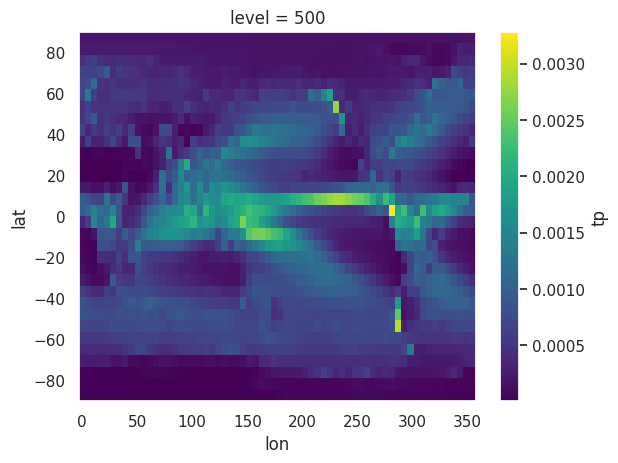

In [19]:
climatology.tp.plot();

In [20]:
print('Saving result:', f'{PREDDIR}/climatology_{res}.nc')
climatology.to_netcdf(  f'{PREDDIR}/climatology_{res}.nc')
#!ls '{PREDDIR}climatology_{res}.nc'

Saving result: /scratch/vp91/mah900/NCI-Weatherbench/pred_dir/climatology_5.625.nc


## Climatology by week

We can create amuch better climatology by taking the seasonal cycle into account. Here we will do this by creating a separate climatology for every week.

In [21]:
def create_weekly_climatology_forecast(ds_train, valid_time):
    ds_train['week'] = ds_train['time.week']
    weekly_averages = ds_train.groupby('week').mean('time')
    valid_time['week'] = valid_time['time.week']
    fc_list = []
    for t in valid_time:
        fc_list.append(weekly_averages.sel(week=t.week))
    return xr.concat(fc_list, dim=valid_time)

In [22]:
%%time 
weekly_climatology = create_weekly_climatology_forecast(train_data, valid_data.time)

/opt/conda/envs/mlenv/lib/python3.9/site-packages/xarray/core/accessor_dt.py:418: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.9/site-packages/xarray/core/accessor_dt.py:418: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(


CPU times: user 57.3 s, sys: 14.2 s, total: 1min 11s
Wall time: 1min 4s


In [23]:
weekly_climatology

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 17520)
Coordinates:
    level    int32 500
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
    week     (time) int64 53 53 53 53 53 53 53 53 53 ... 52 52 52 52 52 52 52 52
  * time     (time) datetime64[ns] 2021-01-01 ... 2022-12-31T23:00:00
Data variables:
    z        (time, lat, lon) float32 5.043e+04 5.044e+04 ... 4.966e+04
    t        (time, lat, lon) float32 256.3 256.4 256.3 ... 251.3 251.3 251.3
    tp       (time, lat, lon) float32 1.057e-05 1.16e-05 ... 0.0001228 0.0001301
    t2m      (time, lat, lon) float32 247.2 246.9 246.6 ... 248.2 248.4 248.6

In [24]:
print ('Saving result:',     f'{PREDDIR}/weekly_climatology_{res}.nc')
weekly_climatology.to_netcdf(f'{PREDDIR}/weekly_climatology_{res}.nc')
#!ls '{PREDDIR}weekly_climatology_{res}.nc'

Saving result: /scratch/vp91/mah900/NCI-Weatherbench/pred_dir/weekly_climatology_5.625.nc


In [28]:
#z500.close();       t850.close();       tp.close();       t2m.close()  
#z500_valid.close(); t850_valid.close(); tp_valid.close(); t2m_valid.close()   
#del z500, t850, tp, t2m, z500_valid, t850_valid, tp_valid, t2m_valid  

#lead_times.close(); persistence.close(); train_data.close(); 
#climatology.close(); weekly_climatology.close();   
#del lead_times, persistence, train_data, climatology, weekly_climatology   
#gc.collect()

IPython.Application.instance().kernel.do_shutdown(True)
IPython.Application.instance().kernel.do_shutdown(True)
client.shutdown()

### Note: Rest is moved to 1-b notebook

# The same for higher resolutions

Not up to date, but previous tests for Z500 and T850 showed that there was only a tiny difference in the scores for different resolutions.

In [4]:
%%time
#START = -13
#END   = None
import warnings
warnings.filterwarnings('ignore')
import os
NOTEBOOK_DIR="/g/data/wb00/admin/testing/weatherbench/NCI_notebooks"
os.chdir(NOTEBOOK_DIR)

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from src.score import *
import logging 
import xarray as xr
import dask
from dask.distributed import Client
import gc
from dask.diagnostics import ProgressBar
import IPython
from dask.distributed import progress

#def initialize_client():
#    # initialize workers
#    client = Client(n_workers=12, threads_per_worker=1) 
    
def reset():
    print("Resetting ...")
    IPython.Application.instance().kernel.do_shutdown(True)
    IPython.Application.instance().kernel.do_shutdown(True)
    #client.shutdown()
    
#for res in ['2.8125','1.40625']:

def create_persistence_forecast(ds, lead_time_h):
    assert lead_time_h > 0, 'Lead time must be greater than 0'
    ds_fc = ds.isel(time=slice(0, -lead_time_h))
    return ds_fc

def create_climatology_forecast(ds_train):
    return ds_train.mean('time')

def create_weekly_climatology_forecast(ds_train, valid_time):
    ds_train['week'] = ds_train['time.week']
    weekly_averages = ds_train.groupby('week').mean('time')
    valid_time['week'] = valid_time['time.week']
    fc_list = []
    for t in valid_time:
        fc_list.append(weekly_averages.sel(week=t.week))
    return xr.concat(fc_list, dim=valid_time)

#def persistence_forecasts (res):   
def baseline_forecasts (res):       
    print (100*'-')
    #DATADIR = f'/media/rasp/Elements/weather-benchmark/{res}deg/'
    DATADIR = f'/g/data/wb00/NCI-Weatherbench/{res}deg/' 
    print(DATADIR)
    PREDDIR = f"/scratch/vp91/{os.environ['USER']}/NCI-Weatherbench/pred_dir" # Location to store baseline forecasts
    print(PREDDIR)
    # Load the entire dataset
    # Load the dataset
    print (f'Loading data, Res: {res} ...')
    #with ProgressBar():
    #z500 = xr.open_mfdataset(f'{DATADIR}geopotential/*.nc', combine='by_coords', parallel=True).z.sel(level=500)
    z500 = xr.open_mfdataset(get_files_list(f'{DATADIR}/geopotential/'), combine='by_coords', parallel=True, chunks={'time': 10}).z.sel(level=500).load()      
    #t850 = xr.open_mfdataset(f'{DATADIR}temperature/*.nc', combine='by_coords', parallel=True).t.sel(level=850)
    t850 = xr.open_mfdataset(get_files_list(f'{DATADIR}/temperature/'),  combine='by_coords', parallel=True, chunks={'time': 10}).t.sel(level=850).load()  
   
    data = xr.merge([z500.drop('level'), t850.drop('level')])
    # Load the validation subset of the data: 2017 and 2018
    # Load the validation subset of the data: 2021 and 2022
    print (f'Loading validation data, Res: {res} ...')
    #z500_valid = load_test_data(f'{DATADIR}geopotential', 'z')
    #t850_valid = load_test_data(f'{DATADIR}temperature', 't')
    z500_valid = load_test_data(f'{DATADIR}/geopotential/', 'z', slice('2021', '2022'))
    t850_valid = load_test_data(f'{DATADIR}/temperature/',  't', slice('2021', '2022'))   
 
    valid_data = xr.merge([z500_valid, t850_valid])
    # Persistence forecast
    print("Persistence forecast ...")
       
    lead_times = xr.DataArray(
    np.arange(6, 126, 6), dims=['lead_time'], coords={'lead_time': np.arange(6, 126, 6)}, name='lead_time')

    persistence = []
    for l in lead_times:
        persistence.append(create_persistence_forecast(valid_data, int(l)))
    persistence = xr.concat(persistence, dim=lead_times)
    #print(persistence)
    print ('Saving result:', f'{PREDDIR}/persistence_{res}.nc')
    persistence.to_netcdf(   f'{PREDDIR}/persistence_{res}.nc')
    # Climatology
    print('Climatology ...')
    #train_data = data.sel(time=slice(None, '2016'))
    #train_data = data.sel(time=slice('2010', '2020'))
    train_data = data.sel(time=slice('1959', '2020'))
    climatology = create_climatology_forecast(train_data)
    #print(climatology)
    print ('Saving result:', f'{PREDDIR}/climatology_{res}.nc')
    climatology.to_netcdf(   f'{PREDDIR}/climatology_{res}.nc')
    # Weekly climatology
    print('Weekly climatology ...')
    weekly_climatology = create_weekly_climatology_forecast(train_data, valid_data.time)
    #print(weekly_climatology)
    print ('Saving result:',     f'{PREDDIR}/weekly_climatology_{res}.nc')
    weekly_climatology.to_netcdf(f'{PREDDIR}/weekly_climatology_{res}.nc')
    
    #z500.close();       t850.close();       tp.close();       t2m.close()  
    #z500_valid.close(); t850_valid.close(); tp_valid.close(); t2m_valid.close()   
    #del z500, t850, tp, t2m, z500_valid, t850_valid, tp_valid, t2m_valid  

    #lead_times.close(); persistence.close(); train_data.close(); 
    #climatology.close(); weekly_climatology.close();   
    #del lead_times, persistence, train_data, climatology, weekly_climatology   
    #gc.collect()
#client    

CPU times: user 92 µs, sys: 65 µs, total: 157 µs
Wall time: 134 µs


In [2]:
%%time
#persistence_forecasts ('2.8125')
#initialize_client()
#reset()
#client = Client(n_workers=12, threads_per_worker=1)
#client
with Client(n_workers=12, threads_per_worker=1) as client: 
    baseline_forecasts('2.8125')
print ("Done")    
reset()

/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.events-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.wa

----------------------------------------------------------------------------------------------------
/g/data/wb00/NCI-Weatherbench/2.8125deg/
/scratch/vp91/mah900/NCI-Weatherbench/pred_dir
Loading data, res 2.8125
Loading validation data, res: 2.8125
var: z
var: t
Persistence forecast
Saving result: /scratch/vp91/mah900/NCI-Weatherbench/pred_dir/persistence_2.8125.nc
Climatology
Saving result: /scratch/vp91/mah900/NCI-Weatherbench/pred_dir/climatology_2.8125.nc
Weekly climatology
Saving result: /scratch/vp91/mah900/NCI-Weatherbench/pred_dir/weekly_climatology_2.8125.nc
CPU times: user 25min 13s, sys: 3min 29s, total: 28min 42s
Wall time: 47min 53s


In [5]:
#IPython.Application.instance().kernel.do_shutdown(True)


In [ ]:
%%time
#client = Client(n_workers=12, threads_per_worker=1)
#client
#persistence_forecasts ('1.40625')
with Client(n_workers=12, threads_per_worker=1) as client: 
    baseline_forecasts ('1.40625')
print ("Done")    
reset()

/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.events-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.wa

----------------------------------------------------------------------------------------------------
/g/data/wb00/NCI-Weatherbench/1.40625deg/
/scratch/vp91/mah900/NCI-Weatherbench/pred_dir
Loading data, Res: 1.40625 ...


In [ ]:
#IPython.Application.instance().kernel.do_shutdown(True)

In [ ]:
#client.shutdown()

# The End